# Load images

This tutorial provides a simple example of how to load an image dataset using `tf.data`.

The dataset used in this example is distributed as directories of images, with one class of image per directory.

## Setup

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [3]:
try:
  # %tensorflow_version only exists in Colab.
  !pip install -q tf-nightly
except Exception:
  pass
import tensorflow as tf

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
import IPython.display as display
from PIL import Image # pip install pillow
import numpy as np
import matplotlib.pyplot as plt
import os

In [6]:
tf.__version__

'2.2.0-dev20200302'

### Retrieve the images

Before you start any training, you will need a set of images to teach the network about the new classes you want to recognize. You can use an archive of creative-commons licensed flower photos from Google.

Note: all images are licensed CC-BY, creators are listed in the `LICENSE.txt` file.

In [7]:
import pathlib
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

After downloading (218MB), you should now have a copy of the flower photos available.

The directory contains 5 sub-directories, one per class:

In [8]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [9]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['roses', 'sunflowers', 'daisy', 'dandelion', 'tulips'],
      dtype='<U10')

Each directory contains images of that type of flower. Here are some roses:

/Users/user/.keras/datasets/flower_photos/roses/16209331331_343c899d38.jpg


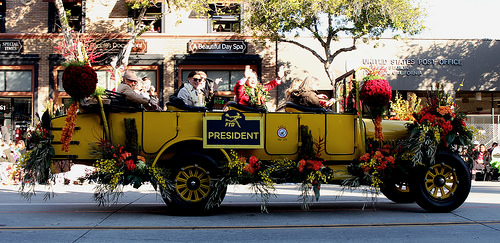

/Users/user/.keras/datasets/flower_photos/roses/5777669976_a205f61e5b.jpg


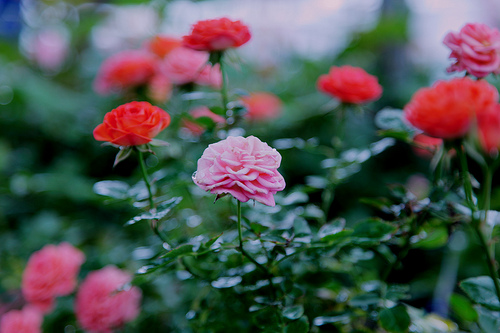

/Users/user/.keras/datasets/flower_photos/roses/4860145119_b1c3cbaa4e_n.jpg


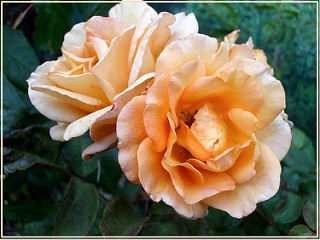

In [10]:
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
    print(image_path)
    display.display(Image.open(str(image_path)))

## Load using `keras.preprocessing`

A simple way to load images is to use `tf.keras.preprocessing`.

In [11]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

Define some parameters for the loader:

In [12]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE) # batch 갯수

In [37]:
#not collections of (`example, label`) pairs, but collections of batches. 
#Each batch is a pair of (*many examples*, *many labels*) represented as arrays.

train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 3670 images belonging to 5 classes.


Inspect a batch:

In [14]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10)) # 상하 좌우 간격
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

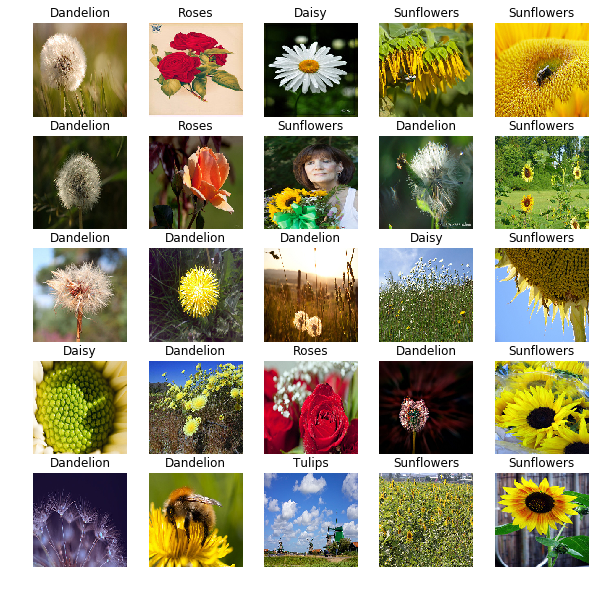

In [39]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

## Load using `tf.data`

The above `keras.preprocessing` method is convienient, but has three downsides: 

1. It's slow. See the performance section below.
1. It lacks fine-grained control.
1. It is not well integrated with the rest of TensorFlow.

To load the files as a `tf.data.Dataset` first create a dataset of the file paths:

In [16]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

b'/Users/user/.keras/datasets/flower_photos/sunflowers/3466923719_b4b6df7f8b_n.jpg'


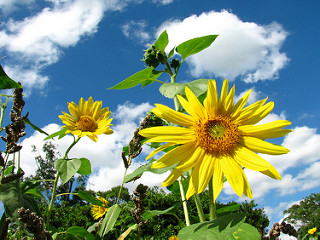

In [17]:
for f in list_ds.take(1):
  print(f.numpy())
  display.display(Image.open(str(f.numpy().decode('UTF-8'))))

Write a short pure-tensorflow function that converts a file paths to an (image_data, label) pair:

In [40]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
    
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES # true false

In [19]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
    
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
    
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [20]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Use `Dataset.map` to create a dataset of `image, label` pairs:

In [41]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE) # like image_generator of keras

In [22]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())
  print(image)

Image shape:  (224, 224, 3)
Label:  [False  True False False False]
tf.Tensor(
[[[0.09411766 0.47450984 0.8431373 ]
  [0.09399823 0.47439042 0.8430179 ]
  [0.09112457 0.47151676 0.8401443 ]
  ...
  [0.09305157 0.49105585 0.8518402 ]
  [0.08977591 0.49369752 0.8544819 ]
  [0.08977591 0.49369752 0.8544819 ]]

 [[0.09369749 0.47408968 0.8427172 ]
  [0.09071191 0.4711041  0.8397316 ]
  [0.09019608 0.47058827 0.83921576]
  ...
  [0.09036914 0.48837346 0.8491578 ]
  [0.07885154 0.48277313 0.8435575 ]
  [0.07885154 0.48277313 0.8435575 ]]

 [[0.09229692 0.47128853 0.83991605]
  [0.09169981 0.47069144 0.83931893]
  [0.09212498 0.4711166  0.8397441 ]
  ...
  [0.09157279 0.48957708 0.85036147]
  [0.0837535  0.4876751  0.8484594 ]
  [0.0837535  0.4876751  0.8484594 ]]

 ...

 [[0.227451   0.627451   0.8862746 ]
  [0.227451   0.627451   0.8862746 ]
  [0.22502065 0.627451   0.8862746 ]
  ...
  [0.23693347 0.6408551  0.9036002 ]
  [0.23207286 0.63599443 0.8987396 ]
  [0.23207286 0.63599443 0.8987396

### Basic methods for training

To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

These features can be easily added using the `tf.data` api.

In [23]:


def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [44]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds)) # collection of batch
image_batch1, label_batch1 = next(iter(train_ds))
print(label_batch)
print(label_batch1)

tf.Tensor(
[[False False  True False False]
 [False False False  True False]
 [False False False False  True]
 [False False False  True False]
 [False False False False  True]
 [ True False False False False]
 [False False False False  True]
 [False False False  True False]
 [False False  True False False]
 [ True False False False False]
 [False False False  True False]
 [False False False  True False]
 [False  True False False False]
 [False False False  True False]
 [False False False False  True]
 [False False False False  True]
 [False False False False  True]
 [False False False False  True]
 [False False  True False False]
 [False  True False False False]
 [ True False False False False]
 [ True False False False False]
 [False False False False  True]
 [False False  True False False]
 [False False False  True False]
 [False  True False False False]
 [False  True False False False]
 [False False False  True False]
 [False  True False False False]
 [False False  True False False]

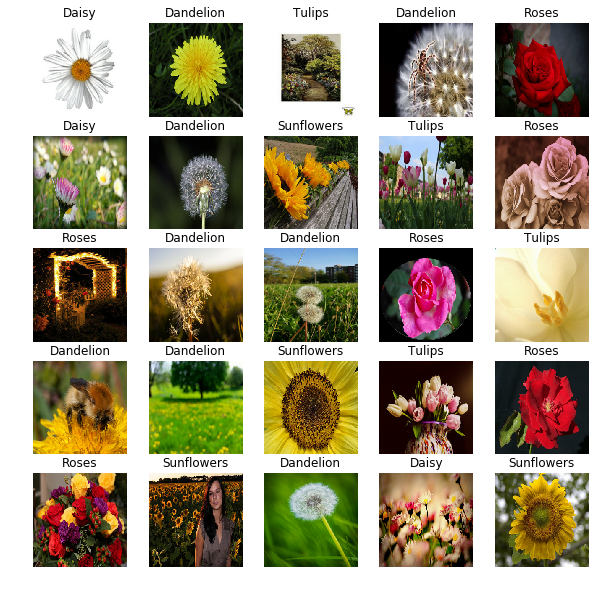

In [31]:
show_batch(image_batch.numpy(), label_batch.numpy()) # image_generator 와 비교시 .numpy() 차이

## Performance

Note: This section just shows a couple of easy tricks that may help performance. For an in depth guide see [Input Pipeline Performance](../../guide/performance/datasets).

To investigate, first here's a function to check the performance of our datasets:

In [46]:
import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)      # 32(batch_size)개 example을 한 스텝당 처리
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))

Let's compare the speed of the two data generators:

In [27]:
# `keras.preprocessing`
timeit(train_data_gen)

....................................................................................................
1000 batches: 76.68282198905945 s
417.30337 Images/s


In [28]:
# `tf.data`
timeit(train_ds)

....................................................................................................
1000 batches: 7.351798057556152 s
4352.67669 Images/s


A large part of the performance gain comes from the use of `.cache`.

In [29]:
uncached_ds = prepare_for_training(labeled_ds, cache=False)
timeit(uncached_ds)

....................................................................................................
1000 batches: 39.683653831481934 s
806.37736 Images/s


If the dataset doesn't fit in memory use a cache file to maintain some of the advantages:

In [30]:
filecache_ds = prepare_for_training(labeled_ds, cache="./flowers.tfcache")
timeit(filecache_ds)

....................................................................................................
1000 batches: 19.874006748199463 s
1610.14336 Images/s
